In [1]:
!pip install python-terrier
import math
import gensim
import pyterrier as pt
import re
import numpy as np
import json
import pandas as pd
import math
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
from SPARQLWrapper import SPARQLWrapper, JSON
import warnings
warnings.filterwarnings("ignore")
import wikipedia
import gensim.downloader as api
import random
from pyrdf2vec.graphs import KG
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.samplers import UniformSampler
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.walkers import RandomWalker
import requests
from utils.py import *

if not pt.started():
    pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


## Chargement des tables et des requetes

In [ ]:
with open('tables_1000.json', 'r') as f:
  # Charger les données JSON dans un dictionnaire Python
  tables = json.load(f)
    
# Ouvrir le fichier en mode lecture
with open('requetes_20.json', 'r') as f:
  # Charger les données JSON dans un dictionnaire Python
  queries = json.load(f)

# Experimentations

In [4]:
corpus = tables['tables']
nb_tables = 1000
nb_queries = 20

In [5]:
vocabulaire = []
for i in range(nb_tables):
    table = corpus[i]
    content_word = content_extraction(table,base='word')
    vocabulaire.extend(content_word)
    
vocabulaire = set(vocabulaire)

### Unsupervised Ranking

In [8]:
scores_unsu_ran_sin = []
scores_unsu_ran_mul = []

for i,table in enumerate(corpus):
    print(f"\nPour la table {i} ")
    q = queries[i]
    print("Score BM25 en utilisant le ranking non supervisé en single field : ",unsuprvised_ranking(table,q))
    scores_unsu_ran_sin.append(unsuprvised_ranking(table,q))
    print("Score BM25 en utilisant le ranking non supervisé en multi field (poids uniforms): ",unsuprvised_ranking(table,q,False))
    scores_unsu_ran_mul.append(unsuprvised_ranking(table,q,False))
    print("Score BM25 en utilisant le ranking non supervisé en multi field (poids non uniforms): ",unsuprvised_ranking(table,q,False,[0.1,0.1,0.1,0.1,0.6]))


Pour la table 0 
Score BM25 en utilisant le ranking non supervisé en single field :  0
Score BM25 en utilisant le ranking non supervisé en multi field (poids uniforms):  0.0
Score BM25 en utilisant le ranking non supervisé en multi field (poids non uniforms):  0.0

Pour la table 1 
Score BM25 en utilisant le ranking non supervisé en single field :  4.394449154672439
Score BM25 en utilisant le ranking non supervisé en multi field (poids uniforms):  0.2716246968306389
Score BM25 en utilisant le ranking non supervisé en multi field (poids non uniforms):  0.13581234841531944

Pour la table 2 
Score BM25 en utilisant le ranking non supervisé en single field :  0
Score BM25 en utilisant le ranking non supervisé en multi field (poids uniforms):  0.0
Score BM25 en utilisant le ranking non supervisé en multi field (poids non uniforms):  0.0

Pour la table 3 
Score BM25 en utilisant le ranking non supervisé en single field :  2.9789251552376097
Score BM25 en utilisant le ranking non supervisé e

In [9]:
ndcg_unsu_rank_sin = []
indices_best_tables = np.argsort(scores_unsu_ran_sin)[::-1]
print("\nSCORE UNSUPERVISED RANKING")
K = [5,6,7,8]
for k in K:
    corpus = np.array(corpus)
    corpus_best = corpus[indices_best_tables]

    relevances = get_relevance(corpus_best)[:k]

    ranking = np.arange(len(relevances))
    score_ndcg = ndcg(ranking,relevances,k)
    ndcg_unsu_rank_sin.append(score_ndcg)
    print(f"NDCG@{k} = ", score_ndcg)
    
    
    
ndcg_unsu_rank_mul = []
indices_best_tables = np.argsort(scores_unsu_ran_mul)[::-1]
print("\nSCORE UNSUPERVISED RANKING")
K = [5,6,7,8]
for k in K:
    corpus = np.array(corpus)
    corpus_best = corpus[indices_best_tables]

    relevances = get_relevance(corpus_best)[:k]

    ranking = np.arange(len(relevances))
    score_ndcg = ndcg(ranking,relevances,k)
    ndcg_unsu_rank_mul.append(score_ndcg)
    print(f"NDCG@{k} = ", score_ndcg)


SCORE UNSUPERVISED RANKING
NDCG@5 =  0.6176324474063534
NDCG@6 =  0.6305224050669415
NDCG@7 =  0.6418215600978554
NDCG@8 =  0.651896411005132

SCORE UNSUPERVISED RANKING
NDCG@5 =  0.666953939877106
NDCG@6 =  0.6781812252073862
NDCG@7 =  0.6880229051308991
NDCG@8 =  0.6967982036054533


## Content Extraction

### Entity Based

In [10]:
tables_content_EB = []
for i in range(nb_tables):
    table = tables['tables'][i]
    content_word = content_extraction(table,base='entity',query=False)
    tables_content_EB.append(content_word)

query_content_EB = []
for i in range(nb_queries):
    content_word = content_extraction(queries[i],base='entity',query=True)
    query_content_EB.append(content_word)

#### Affichage de 10 tables

In [11]:
print("EN BASE ENTITY")
for i in range(11):
    print(f"\nLe contenu pour la table {i} : ")
    print(tables_content_EB[i])

EN BASE ENTITY

Le contenu pour la table 0 : 
{'Bradley', 'external', 'Udo', 'dettmar', 'Awards', 'links', 'Gordon', 'Lattek', 'cramer'}

Le contenu pour la table 1 : 
{'katha', 'climate', 'NOAA', 'burma'}

Le contenu pour la table 2 : 
{'33', 'gone', 'november', 'charts', 'till'}

Le contenu pour la table 3 : 
{'100', 'Hot', 'Track', 'song', 'Oricon', 'mikazuki', 'Chart', 'Digital', 'Japan', 'charts', 'RIAJ', 'Weekly'}

Le contenu pour la table 4 : 
{'satellite', 'sabine', 'craters', 'crater', 'N'}

Le contenu pour la table 5 : 
{'satellite', 'E', 'lunar', 'craters', 'crater', 'secchi'}

Le contenu pour la table 6 : 
{'satellite', 'silberschlag', 'craters', 'crater', 'N'}

Le contenu pour la table 7 : 
{'the', 'london', 'One', 'average', 'attendances', 'valley', 'Division'}

Le contenu pour la table 8 : 
{'london', 'Two', 'South', 'the', 'average', 'attendances', 'valley', 'Division', 'Three'}

Le contenu pour la table 9 : 
{'Premier', 'london', 'First', 'the', 'League', 'attendances'

## Semantic Representation

### Bag of Categories

In [12]:
# construire les categories de tous le corpus
entities_corpus = []
for cont in tables_content_EB:
    entities_corpus.extend(cont)
for cont in query_content_EB:
    entities_corpus.extend(cont)
    
entities_corpus = set(entities_corpus)
categories = get_categories_content(entities_corpus)
print("Nombre de categories pour le corpus : ",len(categories))

Nombre de categories pour le corpus :  310


In [13]:
tables_boc = []
for i in range(nb_tables):
    table = tables['tables'][i]
    content_entity_boc = semantic_representation(tables_content_EB[i],categories,space='boc')
    tables_boc.append(content_entity_boc)
    
query_boc = []
for i in range(nb_queries):
    content_entity_boc = semantic_representation(query_content_EB[i],categories,space='boc')
    query_boc.append(content_entity_boc)

#### Affichage de 10 tables

In [14]:
print("Bag of Categories")
for i in range(11):
    print(f"\nLa representation pour la table {i}: ")
    print(tables_boc[i].shape)

Bag of Categories

La representation pour la table 0: 
(9, 310)

La representation pour la table 1: 
(4, 310)

La representation pour la table 2: 
(5, 310)

La representation pour la table 3: 
(12, 310)

La representation pour la table 4: 
(5, 310)

La representation pour la table 5: 
(6, 310)

La representation pour la table 6: 
(5, 310)

La representation pour la table 7: 
(7, 310)

La representation pour la table 8: 
(9, 310)

La representation pour la table 9: 
(11, 310)

La representation pour la table 10: 
(5, 310)


## Affichage des similarités sur 10 echantillons

In [15]:
print("STRATEGY EARLY")
scores_early = []
for i in range(11):
    simi = similarity(tables_boc[i],query_boc[0],strategy='early',aggr='avg',isEmbedding=False)
    scores_early.append(simi)
    print(f"Similarity entre la table {i} et la requete {i} : " , simi)
    
    
print("\nSTRATEGY LATE-MAX")
for i in range(11):
    simi = similarity(tables_boc[i],query_boc[0],strategy='late',aggr='max',isEmbedding=False)
    print(f"Similarity entre la table {i} et la requete {i} : " , simi)
    
print("\nSTRATEGY LATE-SUM")
for i in range(11):
    simi = similarity(tables_boc[i],query_boc[0],strategy='late',aggr='sum',isEmbedding=False)
    print(f"Similarity entre la table {i} et la requete {i} : " , simi)
    
scores_late_avg = []
print("\nSTRATEGY LATE-AVG")
for i in range(11):
    simi = similarity(tables_boc[i],query_boc[0],strategy='late',aggr='avg',isEmbedding=False)
    scores_late_avg.append(simi)
    print(f"Similarity entre la table {i} et la requete {i} : " , simi)

STRATEGY EARLY
Similarity entre la table 0 et la requete 0 :  0.382270290379836
Similarity entre la table 1 et la requete 1 :  0.3933271858757881
Similarity entre la table 2 et la requete 2 :  0.38556263602602386
Similarity entre la table 3 et la requete 3 :  0.46498421185990907
Similarity entre la table 4 et la requete 4 :  0.384895391281083
Similarity entre la table 5 et la requete 5 :  0.45748847506643686
Similarity entre la table 6 et la requete 6 :  0.40200941576072435
Similarity entre la table 7 et la requete 7 :  0.3946351276715524
Similarity entre la table 8 et la requete 8 :  0.44008080544682815
Similarity entre la table 9 et la requete 9 :  0.4135080551040269
Similarity entre la table 10 et la requete 10 :  0.41832472445048163

STRATEGY LATE-MAX
Similarity entre la table 0 et la requete 0 :  0.3061850825407022
Similarity entre la table 1 et la requete 1 :  0.41079016105037014
Similarity entre la table 2 et la requete 2 :  0.3278036128926708
Similarity entre la table 3 et la r

In [16]:
ndcg_late_average = []
ndcg_late_average = []
indices_best_tables = np.argsort(scores_late_avg)[::-1]
print("\nSCORE LATE AVERAGE")
K = [5,6,7,8]
for k in K:
    corpus = np.array(corpus)
    corpus_best = corpus[indices_best_tables]

    relevances = get_relevance(corpus_best)[:k]

    ranking = np.arange(len(relevances))
    score_ndcg = ndcg(ranking,relevances,k)
    ndcg_late_average.append(score_ndcg)
    print(f"NDCG@{k} = ", score_ndcg)

    
ndcg_early = []
        
indices_best_tables = np.argsort(scores_early)[::-1]
print("\nSCORE EARLY")
K = [5,6,7,8]
for k in K:
    corpus = np.array(corpus)
    corpus_best = corpus[indices_best_tables]

    relevances = get_relevance(corpus_best)[:k]

    ranking = np.arange(len(relevances))
    score_ndcg = ndcg(ranking,relevances,k)
    ndcg_early.append(score_ndcg)
    print(f"NDCG@{k} = ", score_ndcg)


SCORE LATE AVERAGE
NDCG@5 =  1.0
NDCG@6 =  1.0
NDCG@7 =  0.7007429671051125
NDCG@8 =  0.709160475401239

SCORE EARLY
NDCG@5 =  0.614043125579629
NDCG@6 =  0.6270540825406621
NDCG@7 =  0.6384593038512615
NDCG@8 =  0.6486287283749895


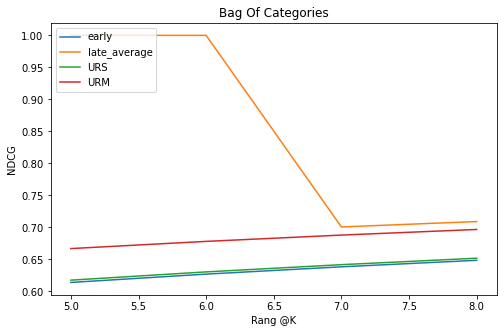

In [18]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
plt.title("Bag Of Categories")
plt.xlabel("Rang @K")
plt.ylabel("NDCG")
plt.plot(K,ndcg_early)
plt.plot(K,ndcg_late_average)
plt.plot(K,ndcg_unsu_rank_sin)
plt.plot(K,ndcg_unsu_rank_mul)
plt.legend(["early","late_average","URS","URM"],loc='upper left')
plt.show()